**Eulerian Animation Overview**

An **Eulerian circuit** is a closed walk through a graph that traverses every edge exactly once and returns to its starting point. In this notebook you will:

- Generate undirected graphs with adjustable size and edge density.  
- Verify that the graph is connected and that every vertex has an even degree—necessary conditions for an Eulerian circuit.  
- Apply Hierholzer’s method to construct the circuit, exploring one cycle at a time and splicing them together.  
- Animate the traversal in Manim: edges light up in the order they are visited, with visual cues for backtracking and cycle merging.  
- Experiment with different random seeds to see how circuit structure changes with graph topology.  


### It is important to first install Manim

In [ ]:
!pip install manim

### Import libraries

In [ ]:
from manim import *
import networkx as nx, numpy as np, random

### Setting where and name of the video

In [2]:
config.media_dir         = r"C:\Users\alejo\OneDrive\Desktop\University\8th_Semester\Data_Structures\Media"  
# HERE: replace this path with a folder located within the directory where your script is running.

config.disable_latex     = True  
# It’s recommended to run this in VSCode and create a dedicated folder (e.g. “Media”) for storing the rendered videos.

config.write_to_movie    = True  
config.output_file       = "EulerianPath"   # This will be the name of the output video file
config.format            = "mp4"  
config.pixel_height      = 720  
config.pixel_width       = 1280  
config.frame_rate        = 30  


## Funciones de utilidad para crear grafos y verificar si se puede recorrer de forma euleriana

In [3]:

def generar_grafo_aleatorio(max_nodes=7, p=0.6):
    """
    Generate a random undirected graph using the G(n, p) model.

    Parameters
    ----------
    max_nodes : int, optional
        Maximum number of nodes in the graph (default is 7).
    p : float, optional
        Probability for edge creation between any pair of nodes (default is 0.6).

    Returns
    -------
    networkx.Graph
        A random graph with between 3 and max_nodes vertices, guaranteed to have
        no isolated nodes (every node has degree ≥ 1).
    """
    while True:
        # Choose a random number of nodes between 3 and max_nodes
        n = random.randint(3, max_nodes)
        # Create a G(n, p) random graph
        G = nx.gnp_random_graph(n, p)
        # If there are no isolated nodes, return the graph
        if not list(nx.isolates(G)):
            return G

def es_euleriano(G):
    """
    Return True if G admits an Eulerian trail or circuit.

    Parameters
    ----------
    G : networkx.Graph
        An undirected graph.

    Returns
    -------
    bool
        True if G is connected and has either 0 or 2 vertices of odd degree,
        which corresponds to an Eulerian circuit (0 odd‐degree vertices)
        or an Eulerian path (2 odd‐degree vertices).
    """
    odd = [v for v, d in G.degree() if d % 2 == 1]
    return len(odd) in (0, 2) and nx.is_connected(G)

def hierholzer(G):
    """
    Return the Eulerian traversal of G as (vertices, edges), or None if no Eulerian path/circuit exists.

    Parameters
    ----------
    G : networkx.Graph
        An undirected graph.

    Returns
    -------
    tuple or None
        - vertices: list of nodes in the order they are visited
        - edges: list of (u, v) tuples in the same order
        Returns None if the graph is not Eulerian.
    """
    # Check Eulerian conditions (connected & 0 or 2 odd‐degree nodes)
    if not es_euleriano(G):
        return None

    H = G.copy()
    # Choose start node: an odd‐degree node if present, else any node
    start = next((v for v, d in H.degree() if d % 2), list(H.nodes())[0])

    stack, path = [start], []  # stack for current path, path for final tour

    # Continue until all edges are exhausted
    while stack:
        v = stack[-1]
        if H.degree(v) > 0:
            # Follow an unused edge (v, w)
            w = next(iter(H.neighbors(v)))
            stack.append(w)
            H.remove_edge(v, w)  # mark edge as used
        else:
            # Backtrack: add vertex to circuit when no more edges remain
            path.append(stack.pop())

    verts = path[::-1]  # reverse to get correct order
    # Pair consecutive vertices to form edges
    edges = list(zip(verts[:-1], verts[1:]))
    return verts, edges

## With this function you can visualize the graph that will be presented in the video

([0, 3, 1, 2, 3, 4, 2, 5, 3], [(0, 3), (3, 1), (1, 2), (2, 3), (3, 4), (4, 2), (2, 5), (5, 3)])


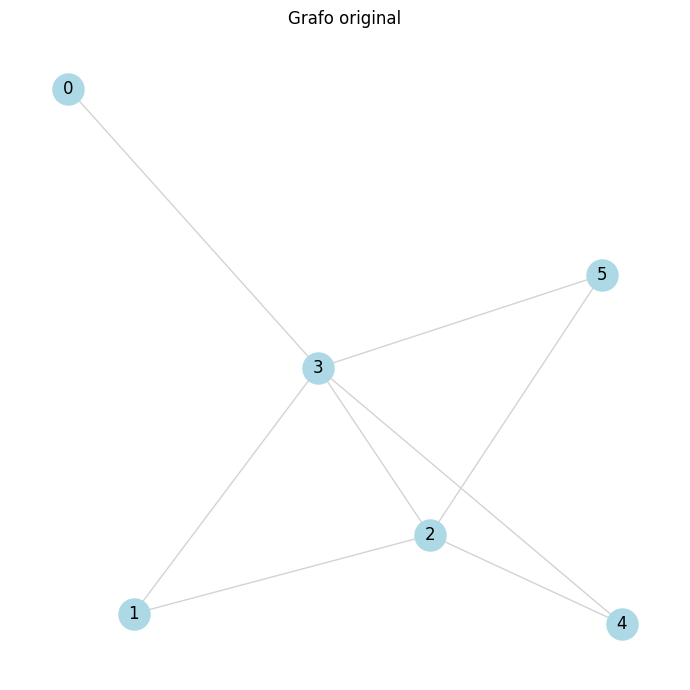

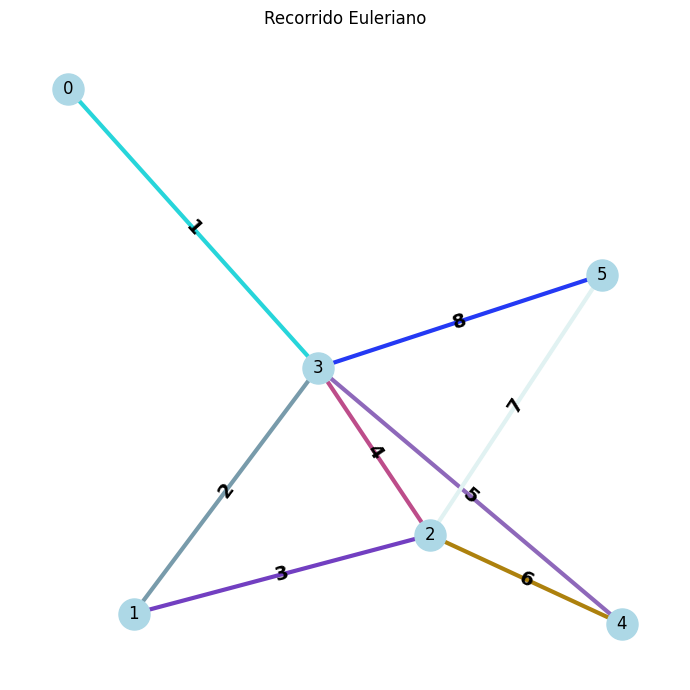

In [6]:
import matplotlib.pyplot as plt

G = generar_grafo_aleatorio()  
recorrido = hierholzer(G)
print(recorrido)    

def dibujar_euleriano(G, recorrido, layout="spring",
                      node_size=500, base_edge_color="lightgray"):
    """
    Dibuja dos vistas de G:
     1) el grafo original
     2) el grafo resaltando un recorrido euleriano con un color aleatorio por arista
        y una etiqueta numerada en el centro de cada arista del recorrido.
    """

    # ————————————— Verificación —————————————


    if isinstance(recorrido, tuple) and len(recorrido) == 2:
        vertices, edg_seq = recorrido
    else:
        vertices = recorrido
        edg_seq  = list(zip(vertices[:-1], vertices[1:]))

    if len(edg_seq) == 0:
        print("El grafo no tiene aristas que recorrer.")
        return

    # ————————————— Layout —————————————
    if layout == "spring":
        pos = nx.spring_layout(G)
    else:
        try:
            pos = getattr(nx, f"{layout}_layout")(G)
        except AttributeError:
            raise ValueError(f"Layout desconocido: {layout!r}")

    # ————————————— Preparar colores para el recorrido —————————————
    n = len(edg_seq)
    colors = []
    seen = set()
    for _ in range(n):
        c = "#{:06x}".format(random.randint(0, 0xFFFFFF))
        while c in seen:
            c = "#{:06x}".format(random.randint(0, 0xFFFFFF))
        seen.add(c)
        colors.append(c)

    # ————————————— 1) Grafo original —————————————
    plt.figure(figsize=(7, 7))
    nx.draw_networkx(
        G, pos,
        node_color="lightblue",
        edge_color=base_edge_color,
        with_labels=True,
        node_size=node_size,
    )
    plt.title("Grafo original")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    # ————————————— 2) Grafo con recorrido euleriano —————————————
    plt.figure(figsize=(7, 7))
    # dibujar grafo de fondo
    nx.draw_networkx(
        G, pos,
        node_color="lightblue",
        edge_color=base_edge_color,
        with_labels=True,
        node_size=node_size,
    )
    # sobreimprimir cada arista del recorrido
    for i, (u, v) in enumerate(edg_seq, start=1):
        color = colors[i - 1]
        nx.draw_networkx_edges(
            G, pos,
            edgelist=[(u, v)],
            width=3,
            edge_color=[color]
        )
        nx.draw_networkx_edge_labels(
            G, pos,
            edge_labels = {(u, v): str(i)},
            font_color  = 'black',
            font_size   = 14,
            font_weight = 'bold',
            label_pos   = 0.5,
            rotate      = True,
            bbox        = dict(alpha=0)
        )

    plt.title("Recorrido Euleriano")
    plt.axis("off")
    plt.tight_layout()
    plt.show()
    
dibujar_euleriano(G, recorrido) 


### This is how the end of the graph will look in the video... Since we are creating random graphs, my recommendation is that you run the above chunk several times until a graph is to your liking and then run the code below that generates the video. 

### This is also recommended because if the graph cannot be traversed in Euclidean form, you will know before running the render.

### Now, due to how the interaction between Manim and NetoworX works, the graph may be in a different orientation than how it is seen above in the video, as if it were turned or rotated... but all the edges will be the same and the vectors will connect correctly.

In [7]:
%%manim -qh EulerianPath 
### Este codigo de arriba es sumamente importante, es el que permite que el render corra en jupyter si se cambia por -qk se guardara en 4k 

from manim import *
import random
import colorsys

def pastel_mediano():
    """
    Devuelve un color pastel cuyo lightness (luminosidad)
    está entre 0.5 y 0.7, y saturación moderada.
    """
    h = random.random()                      
    s = random.uniform(0.4, 0.6)              
    l = random.uniform(0.5, 0.7)              
    r, g, b = colorsys.hls_to_rgb(h, l, s)
    return "#{:02x}{:02x}{:02x}".format(int(r * 255),int(g * 255),int(b * 255),)

G_nx = G
verts, ars = recorrido 

class EulerianPath(Scene):
    def construct(self):
        # Retícula 
        self.camera.background_color = BLACK
        plane = NumberPlane(
            x_range=[-8, 8, 1],
            y_range=[-4.5, 4.5, 1],
            background_line_style={
                "stroke_color": DARK_GRAY,
                "stroke_width": 0.8,
                "stroke_opacity": 0.6,
            },
        ).set_z_index(-10)
        plane.axes.set_opacity(0)  
        self.add(plane)

        # Posiciones reproducibles de NetworkX → Manim
        pos_nx = nx.spring_layout(G_nx, seed=42)
        pos    = {v: np.array([x, y, 0])*3 for v, (x, y) in pos_nx.items()}

        # Nodos con aparición lenta
        nodos  = VGroup(*[Dot(pos[v], radius=0.28, color=BLUE_E) for v in G_nx]) ## Color de los nodos
        labels = VGroup(*[Text(str(v), 24, color=WHITE).next_to(pos[v], UP*0.35) for v in G_nx])
        for dot, lab in zip(nodos, labels):
            self.play(GrowFromCenter(dot), FadeIn(lab), run_time=0.35)
        self.wait(0.25)

        # Aristas de fondo en gris
        for u, v in G_nx.edges():
            self.add(Line(pos[u], pos[v], color=GRAY_E, stroke_width=2))

        # Paleta pastel para resaltar cada arista
        palette = []
        while len(palette) < len(ars):
            c = pastel_mediano()
            if c not in palette:
                palette.append(c)

        # Contador superior pequeño
        contador = Text("", font_size=24, color=YELLOW).to_edge(UP)
        self.add(contador)

        # Recorrido euleriano animado
        for i, (u, v) in enumerate(ars, 1):
            col = palette[i-1]

            # Actualiza contador
            nuevo = Text(f"Paso {i}:  {u} → {v}",font_size=24, color=YELLOW).to_edge(UP)
            self.play(Transform(contador, nuevo), run_time=0.25)

            # Dibuja la arista resaltada
            self.play(Create(Line(pos[u], pos[v], color=col, stroke_width=6)),run_time=0.45)

            # Número del paso 
            num = Text(str(i), font_size=22, weight=BOLD, color=WHITE).move_to((pos[u] + pos[v]) / 2)
            self.play(FadeIn(num, scale=0.5), run_time=0.25)

        self.wait(2.3)


Manim Community v0.19.0

[05/29/25 22:20:00] INFO     Animation 0 : Partial movie file written in                   ]8;id=847836;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=956781;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py#588\588]8;;\
                             'C:\Users\alejo\OneDrive\Escritorio\Universidaad\8                                    
                             semestre\Estructura de Datos\Media\videos\Estructura de                               
                             Datos\1080p60\partial_movie_files\EulerianPath\3529212410_393                         
                             9851047_2357708038.mp4'                                                               

[05/29/25 22:20:01] INFO     Animation 1 : Partial movie file written in                   ]8;id=639882;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=794404;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py#588\588]8;;\
                             'C:\Users\alejo\OneDrive\Escritorio\Universidaad\8                                    
                             semestre\Estructura de Datos\Media\videos\Estructura de                               
                             Datos\1080p60\partial_movie_files\EulerianPath\3040924799_246                         
                             499209_3861789604.mp4'                                                                

                    INFO     Animation 2 : Partial movie file written in                   ]8;id=686396;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=393243;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py#588\588]8;;\
                             'C:\Users\alejo\OneDrive\Escritorio\Universidaad\8                                    
                             semestre\Estructura de Datos\Media\videos\Estructura de                               
                             Datos\1080p60\partial_movie_files\EulerianPath\3040924799_301                         
                             6013186_3681499084.mp4'                                                               

[05/29/25 22:20:02] INFO     Animation 3 : Partial movie file written in                   ]8;id=97252;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=790496;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py#588\588]8;;\
                             'C:\Users\alejo\OneDrive\Escritorio\Universidaad\8                                    
                             semestre\Estructura de Datos\Media\videos\Estructura de                               
                             Datos\1080p60\partial_movie_files\EulerianPath\3040924799_890                         
                             727471_4247051245.mp4'                                                                

                    INFO     Animation 4 : Partial movie file written in                   ]8;id=173171;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=206376;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py#588\588]8;;\
                             'C:\Users\alejo\OneDrive\Escritorio\Universidaad\8                                    
                             semestre\Estructura de Datos\Media\videos\Estructura de                               
                             Datos\1080p60\partial_movie_files\EulerianPath\3040924799_135                         
                             6381135_2669559607.mp4'                                                               

[05/29/25 22:20:03] INFO     Animation 5 : Partial movie file written in                   ]8;id=730523;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=370545;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py#588\588]8;;\
                             'C:\Users\alejo\OneDrive\Escritorio\Universidaad\8                                    
                             semestre\Estructura de Datos\Media\videos\Estructura de                               
                             Datos\1080p60\partial_movie_files\EulerianPath\3040924799_354                         
                             5149985_539862409.mp4'                                                                

                    INFO     Animation 6 : Partial movie file written in                   ]8;id=973680;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=581781;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py#588\588]8;;\
                             'C:\Users\alejo\OneDrive\Escritorio\Universidaad\8                                    
                             semestre\Estructura de Datos\Media\videos\Estructura de                               
                             Datos\1080p60\partial_movie_files\EulerianPath\3040924799_198                         
                             5109552_4129776155.mp4'                                                               

[05/29/25 22:20:04] INFO     Animation 7 : Partial movie file written in                   ]8;id=455520;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=396521;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py#588\588]8;;\
                             'C:\Users\alejo\OneDrive\Escritorio\Universidaad\8                                    
                             semestre\Estructura de Datos\Media\videos\Estructura de                               
                             Datos\1080p60\partial_movie_files\EulerianPath\3040924799_344                         
                             4666867_2784518614.mp4'                                                               

[05/29/25 22:20:05] INFO     Animation 8 : Partial movie file written in                   ]8;id=515111;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=923208;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py#588\588]8;;\
                             'C:\Users\alejo\OneDrive\Escritorio\Universidaad\8                                    
                             semestre\Estructura de Datos\Media\videos\Estructura de                               
                             Datos\1080p60\partial_movie_files\EulerianPath\3040924799_424                         
                             0753156_3891549942.mp4'                                                               

                    INFO     Animation 9 : Partial movie file written in                   ]8;id=720955;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=456326;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py#588\588]8;;\
                             'C:\Users\alejo\OneDrive\Escritorio\Universidaad\8                                    
                             semestre\Estructura de Datos\Media\videos\Estructura de                               
                             Datos\1080p60\partial_movie_files\EulerianPath\3040924799_372                         
                             3531139_731115678.mp4'                                                                

[05/29/25 22:20:06] INFO     Animation 10 : Partial movie file written in                  ]8;id=503979;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=394113;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py#588\588]8;;\
                             'C:\Users\alejo\OneDrive\Escritorio\Universidaad\8                                    
                             semestre\Estructura de Datos\Media\videos\Estructura de                               
                             Datos\1080p60\partial_movie_files\EulerianPath\3040924799_350                         
                             5468721_394575344.mp4'                                                                

[05/29/25 22:20:07] INFO     Animation 11 : Partial movie file written in                  ]8;id=705235;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=153118;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py#588\588]8;;\
                             'C:\Users\alejo\OneDrive\Escritorio\Universidaad\8                                    
                             semestre\Estructura de Datos\Media\videos\Estructura de                               
                             Datos\1080p60\partial_movie_files\EulerianPath\3040924799_151                         
                             4891903_1607705904.mp4'                                                               

                    INFO     Animation 12 : Partial movie file written in                  ]8;id=425999;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=139748;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py#588\588]8;;\
                             'C:\Users\alejo\OneDrive\Escritorio\Universidaad\8                                    
                             semestre\Estructura de Datos\Media\videos\Estructura de                               
                             Datos\1080p60\partial_movie_files\EulerianPath\3040924799_964                         
                             399314_4105958684.mp4'                                                                

[05/29/25 22:20:08] INFO     Animation 13 : Partial movie file written in                  ]8;id=480917;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=610204;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py#588\588]8;;\
                             'C:\Users\alejo\OneDrive\Escritorio\Universidaad\8                                    
                             semestre\Estructura de Datos\Media\videos\Estructura de                               
                             Datos\1080p60\partial_movie_files\EulerianPath\3040924799_427                         
                             4296094_3703652923.mp4'                                                               

                    INFO     Animation 14 : Partial movie file written in                  ]8;id=348518;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=431781;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py#588\588]8;;\
                             'C:\Users\alejo\OneDrive\Escritorio\Universidaad\8                                    
                             semestre\Estructura de Datos\Media\videos\Estructura de                               
                             Datos\1080p60\partial_movie_files\EulerianPath\3040924799_766                         
                             513145_585938258.mp4'                                                                 

[05/29/25 22:20:09] INFO     Animation 15 : Partial movie file written in                  ]8;id=667516;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=605831;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py#588\588]8;;\
                             'C:\Users\alejo\OneDrive\Escritorio\Universidaad\8                                    
                             semestre\Estructura de Datos\Media\videos\Estructura de                               
                             Datos\1080p60\partial_movie_files\EulerianPath\3040924799_106                         
                             8004442_3551621818.mp4'                                                               

                    INFO     Animation 16 : Partial movie file written in                  ]8;id=84907;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=452649;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py#588\588]8;;\
                             'C:\Users\alejo\OneDrive\Escritorio\Universidaad\8                                    
                             semestre\Estructura de Datos\Media\videos\Estructura de                               
                             Datos\1080p60\partial_movie_files\EulerianPath\3040924799_224                         
                             3751367_1923977203.mp4'                                                               

[05/29/25 22:20:10] INFO     Animation 17 : Partial movie file written in                  ]8;id=321879;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=570839;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py#588\588]8;;\
                             'C:\Users\alejo\OneDrive\Escritorio\Universidaad\8                                    
                             semestre\Estructura de Datos\Media\videos\Estructura de                               
                             Datos\1080p60\partial_movie_files\EulerianPath\3040924799_104                         
                             2297998_1564273323.mp4'                                                               

                    INFO     Animation 18 : Partial movie file written in                  ]8;id=861599;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=499032;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py#588\588]8;;\
                             'C:\Users\alejo\OneDrive\Escritorio\Universidaad\8                                    
                             semestre\Estructura de Datos\Media\videos\Estructura de                               
                             Datos\1080p60\partial_movie_files\EulerianPath\3040924799_330                         
                             0163632_326429732.mp4'                                                                

[05/29/25 22:20:11] INFO     Animation 19 : Partial movie file written in                  ]8;id=878090;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=692066;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py#588\588]8;;\
                             'C:\Users\alejo\OneDrive\Escritorio\Universidaad\8                                    
                             semestre\Estructura de Datos\Media\videos\Estructura de                               
                             Datos\1080p60\partial_movie_files\EulerianPath\3040924799_154                         
                             3775107_3759694014.mp4'                                                               

[05/29/25 22:20:12] INFO     Animation 20 : Partial movie file written in                  ]8;id=422111;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=461488;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py#588\588]8;;\
                             'C:\Users\alejo\OneDrive\Escritorio\Universidaad\8                                    
                             semestre\Estructura de Datos\Media\videos\Estructura de                               
                             Datos\1080p60\partial_movie_files\EulerianPath\3040924799_395                         
                             5314082_1599036741.mp4'                                                               

                    INFO     Animation 21 : Partial movie file written in                  ]8;id=104008;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=511379;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py#588\588]8;;\
                             'C:\Users\alejo\OneDrive\Escritorio\Universidaad\8                                    
                             semestre\Estructura de Datos\Media\videos\Estructura de                               
                             Datos\1080p60\partial_movie_files\EulerianPath\3040924799_133                         
                             4030944_802600085.mp4'                                                                

[05/29/25 22:20:13] INFO     Animation 22 : Partial movie file written in                  ]8;id=653279;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=434402;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py#588\588]8;;\
                             'C:\Users\alejo\OneDrive\Escritorio\Universidaad\8                                    
                             semestre\Estructura de Datos\Media\videos\Estructura de                               
                             Datos\1080p60\partial_movie_files\EulerianPath\3040924799_162                         
                             525435_3582950436.mp4'                                                                

[05/29/25 22:20:14] INFO     Animation 23 : Partial movie file written in                  ]8;id=323960;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=464571;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py#588\588]8;;\
                             'C:\Users\alejo\OneDrive\Escritorio\Universidaad\8                                    
                             semestre\Estructura de Datos\Media\videos\Estructura de                               
                             Datos\1080p60\partial_movie_files\EulerianPath\3040924799_419                         
                             0112582_3118189618.mp4'                                                               

                    INFO     Animation 24 : Partial movie file written in                  ]8;id=718114;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=544301;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py#588\588]8;;\
                             'C:\Users\alejo\OneDrive\Escritorio\Universidaad\8                                    
                             semestre\Estructura de Datos\Media\videos\Estructura de                               
                             Datos\1080p60\partial_movie_files\EulerianPath\3040924799_225                         
                             0363676_1440287707.mp4'                                                               

[05/29/25 22:20:15] INFO     Animation 25 : Partial movie file written in                  ]8;id=111762;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=905194;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py#588\588]8;;\
                             'C:\Users\alejo\OneDrive\Escritorio\Universidaad\8                                    
                             semestre\Estructura de Datos\Media\videos\Estructura de                               
                             Datos\1080p60\partial_movie_files\EulerianPath\3040924799_148                         
                             5022633_821005341.mp4'                                                                

                    INFO     Animation 26 : Partial movie file written in                  ]8;id=307515;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=503673;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py#588\588]8;;\
                             'C:\Users\alejo\OneDrive\Escritorio\Universidaad\8                                    
                             semestre\Estructura de Datos\Media\videos\Estructura de                               
                             Datos\1080p60\partial_movie_files\EulerianPath\3040924799_354                         
                             1315889_3256873920.mp4'                                                               

[05/29/25 22:20:16] INFO     Animation 27 : Partial movie file written in                  ]8;id=457623;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=792480;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py#588\588]8;;\
                             'C:\Users\alejo\OneDrive\Escritorio\Universidaad\8                                    
                             semestre\Estructura de Datos\Media\videos\Estructura de                               
                             Datos\1080p60\partial_movie_files\EulerianPath\3040924799_279                         
                             5868248_1026771634.mp4'                                                               

                    INFO     Animation 28 : Partial movie file written in                  ]8;id=959582;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=254731;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py#588\588]8;;\
                             'C:\Users\alejo\OneDrive\Escritorio\Universidaad\8                                    
                             semestre\Estructura de Datos\Media\videos\Estructura de                               
                             Datos\1080p60\partial_movie_files\EulerianPath\3040924799_241                         
                             1590089_4057941027.mp4'                                                               

[05/29/25 22:20:17] INFO     Animation 29 : Partial movie file written in                  ]8;id=360689;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=651682;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py#588\588]8;;\
                             'C:\Users\alejo\OneDrive\Escritorio\Universidaad\8                                    
                             semestre\Estructura de Datos\Media\videos\Estructura de                               
                             Datos\1080p60\partial_movie_files\EulerianPath\3040924799_376                         
                             2444840_2081521744.mp4'                                                               

                    INFO     Animation 30 : Partial movie file written in                  ]8;id=338716;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=591146;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py#588\588]8;;\
                             'C:\Users\alejo\OneDrive\Escritorio\Universidaad\8                                    
                             semestre\Estructura de Datos\Media\videos\Estructura de                               
                             Datos\1080p60\partial_movie_files\EulerianPath\3040924799_303                         
                             0091071_1515711207.mp4'                                                               

[05/29/25 22:20:20] INFO     Animation 31 : Partial movie file written in                  ]8;id=227208;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=568645;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py#588\588]8;;\
                             'C:\Users\alejo\OneDrive\Escritorio\Universidaad\8                                    
                             semestre\Estructura de Datos\Media\videos\Estructura de                               
                             Datos\1080p60\partial_movie_files\EulerianPath\3040924799_106                         
                             8971395_3964237510.mp4'                                                               

                    INFO     Combining to Movie file.                                      ]8;id=896259;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=936043;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py#739\739]8;;\

                    INFO                                                                   ]8;id=622234;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=49841;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py#886\886]8;;\
                             File ready at                                                                         
                             'C:\Users\alejo\OneDrive\Escritorio\Universidaad\8                                    
                             semestre\Estructura de Datos\Media\videos\Estructura de                               
                             Datos\1080p60\EulerianPath.mp4'                                                       
                                                                                                                   

                    INFO     The partial movie directory is full (> 100 files). Therefore, ]8;id=816971;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=962008;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene_file_writer.py#856\856]8;;\
                             manim has removed the 32 oldest file(s). You can change this                          
                             behaviour by changing max_files_cached in config.                                     

                    INFO     Rendered EulerianPath                                                     ]8;id=527417;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene.py\scene.py]8;;\:]8;id=845948;file://C:\Users\alejo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\manim\scene\scene.py#255\255]8;;\
                             Played 32 animations                                                                  

### This code creates the video graph... It should be inside the **folder name you created** -> videos -> Large folder name -> 1080p60

### Finally, the videos are overwritten, so it is recommended that if you want to save a video, you remove it from the folder to save it because if you run this code again with another graph, the last video created will be lost.

### Pablo Reyes 